# Modeling the Two-Body Problem (Earth-Sun)

## Setting up Constrainsts, define masses, and necessary laws:

### Define Masses:
$m_1$ = Mass of Earth <br>
$m_2$ = Mass of Sun <br>
$r_1$ = position of m1 <br>
$r_2$ = position of m2 <br>

### The center of mass between two bodies (barycenter) :
$$R_{cm} = \frac{m1r1 + m2r2}{m1 + m2}$$
### Displacement Vector:
$$r_{12} = r_1 - r_2$$ <br>
$$r_{21} = r_2 - r_1$$
### Newtons Law of universal attraction:
$$F = G\frac{m_1m_2}{r^2}$$ 
[Wiki](https://en.wikipedia.org/wiki/Newton%27s_law_of_universal_gravitation)

### Vector version of Newtons Law of universal attration (direction property):
$$\vec{F}_{12} = -G\frac{m_1m_2}{r^2}\hat{r}_{12} = -G\frac{m_1m_2}{r^3}\vec{r}_{12}$$ <br>
$$\vec{F}_{21} = -G\frac{m_1m_2}{r^2}\hat{r}_{21} = -G\frac{m_1m_2}{r^3}\vec{r}_{21}$$

### Apply Newton's second law to get acceleration equaitons for each body:<br>
$$\vec{F} = m\vec{a}$$ <br>
Body 1:<br>
$$m_1\ddot{r}_1 = \vec{12}$$<br>
Substitute vector gravity formula from above: <br>
$$m_1\ddot{\vec{r}_1}_1 = -G\frac{m_1m_2}{|\vec{r}_1-\vec{r}_2|^3}(\vec{r}_1-\vec{r}_2)$$<br>
$$\ddot{\vec{r}_1} = -Gm_2\frac{\vec{r}_1-\vec{r}_2}{|\vec{r}_1-\vec{r}_2|^3}$$ <br>
Body 2:<br>
$$\ddot{\vec{r}_2} = Gm_1\frac{\vec{r}_2-\vec{r}_1}{|\vec{r}_2-\vec{r}_1|^3}$$ <br>
sign flips since $r_2 - r_1 = -(r_1-r_2)$


### Relative position (vector pointing from body 2 to body 1 or coordinate for gravity): <br>
$$r = r_1 - r_2$$ <br>
$\dot{r}$ = how seperation changes over time <br>
$\ddot{r}$ = acceleration of the seperation, ie, how gravity is curving the motion between the two bodies.

### Relative acceleration ($\ddot{r}$):<br>
$$\ddot{r} = \ddot{r}_1 - \ddot{r}_2$$ <br>
$$\ddot{r} = \left(Gm_2\frac{r}{|r|^3}\right) - \left(+Gm_1\frac{r}{|r|^3}\right)$$<br>
$$\ddot{r} = -G\frac{r}{|r|^3}(m_2+m_1)$$<br>
$$\ddot{r} = -G(m_1+m_2)\frac{r}{|r|^3}$$

## Model

v_circ = 29784.974926416788 m/s
v0     = 25317.22868745427 m/s  (factor = 0.85 )
v_esc  = 42122.3154958812 m/s


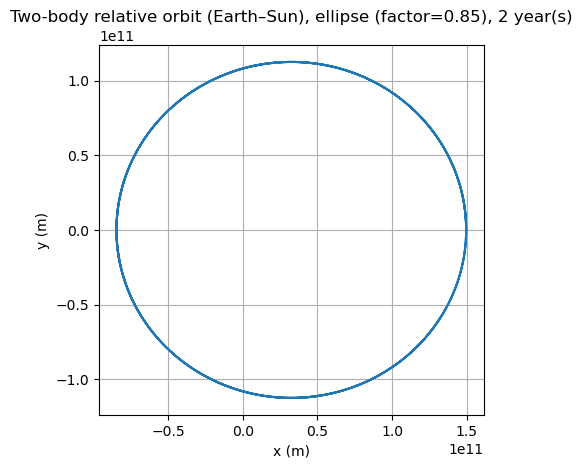

eccentricity e = 0.2775000000000001
e_vec = [-0.2775  0.      0.    ]


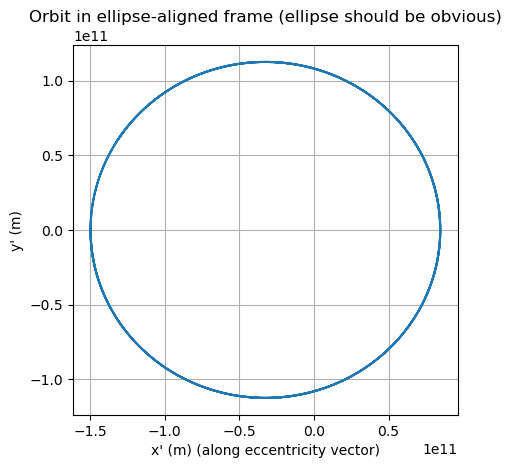

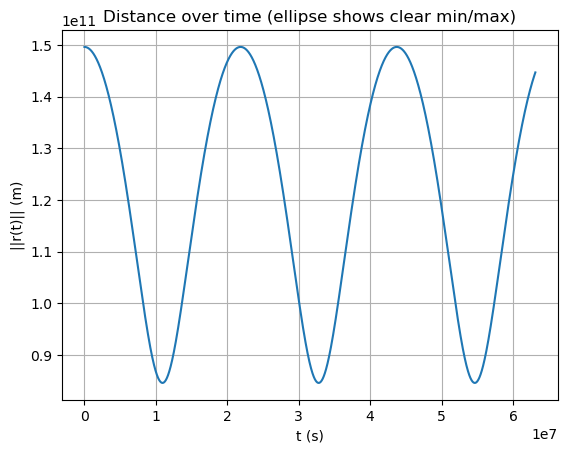

r_min = 84607462296.57704
r_max = 149600000000.0
approx eccentricity from min/max: 0.27749985874114835


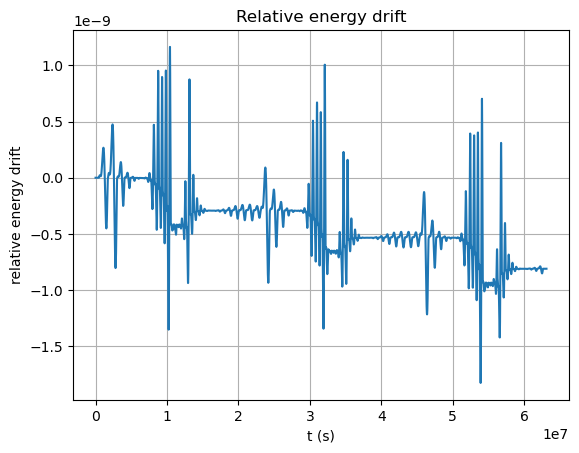

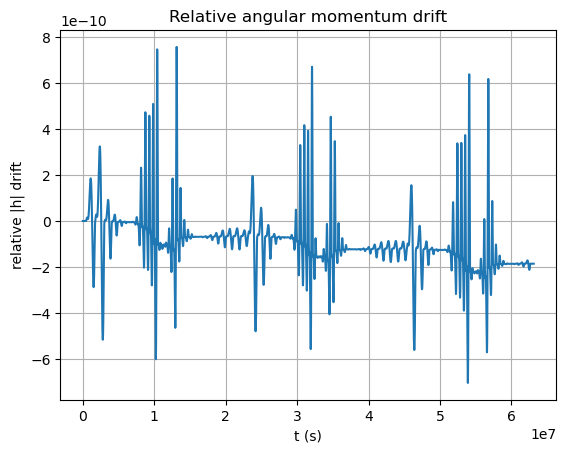

In [1]:
# Two-Body Problem (Earth–Sun) — Python Notebook Template (ELLIPSE VERSION)
# -----------------------------------------------------------------------
# Change: set v0 to be a small factor times the circular speed instead of a fixed number to model ellipse

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# ----------------------------
# 1) Constants (SI units)
# ----------------------------
G = 6.67430e-11  # m^3 / (kg s^2)

m_sun = 1.98847e30     # kg
m_earth = 5.9722e24    # kg

mu = G * (m_sun + m_earth)  # gravitational parameter for relative motion

# ----------------------------
# 2) Initial conditions
# ----------------------------
r0 = np.array([1.496e11, 0.0, 0.0])     # meters (about 1 AU)

# --- CHANGED: compute circular speed and scale it ---
r0_mag = np.linalg.norm(r0)
v_circ = np.sqrt(mu / r0_mag)           # circular speed at r0
v_esc  = np.sqrt(2 * mu / r0_mag)       # escape speed at r0 (for reference)

factor = 0.85  # <--- CHANGED: try 0.995, 0.99, 1.005, 1.01
v0 = np.array([0.0, factor * v_circ, 0.0])

print("v_circ =", v_circ, "m/s")
print("v0     =", np.linalg.norm(v0), "m/s  (factor =", factor, ")")
print("v_esc  =", v_esc, "m/s")

y0 = np.hstack([r0, v0])  # state = [r, v] in R^6

# ----------------------------
# 3) ODE: relative two-body
# ----------------------------
def two_body_relative(t: float, y: np.ndarray, mu: float) -> np.ndarray:
    r = y[:3]
    v = y[3:]

    r_norm = np.linalg.norm(r)
    if r_norm == 0:
        raise ValueError("Encountered r_norm = 0 (collision / singularity).")

    a = -mu * r / r_norm**3
    return np.hstack([v, a])

# ----------------------------
# 4) Simulation horizon
# ----------------------------
years = 2

T = years * 365.25 * 24 * 3600  # seconds
t_span = (0.0, T)

n_points = 5000
t_eval = np.linspace(t_span[0], t_span[1], n_points)

sol = solve_ivp(
    fun=lambda t, y: two_body_relative(t, y, mu),
    t_span=t_span,
    y0=y0,
    method="DOP853",
    rtol=1e-10,
    atol=1e-12,
    t_eval=t_eval,
)

if not sol.success:
    raise RuntimeError(f"ODE solver failed: {sol.message}")

t = sol.t
Y = sol.y.T

r = Y[:, :3]
v = Y[:, 3:]

# ----------------------------
# 5) Plots: orbit + radius
# ----------------------------
plt.figure()
plt.plot(r[:, 0], r[:, 1])
plt.gca().set_aspect("equal", adjustable="box")
plt.grid(True)
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title(f"Two-body relative orbit (Earth–Sun), ellipse (factor={factor}), {years} year(s)")
plt.show()


# --- pick one time index (0 is fine) ---
i = 0
r0_vec = r[i]
v0_vec = v[i]

r0_mag = np.linalg.norm(r0_vec)
v0_mag = np.linalg.norm(v0_vec)

# Specific angular momentum vector
h0 = np.cross(r0_vec, v0_vec)

# Eccentricity vector: e = (v x h)/mu - r/|r|
e_vec = (np.cross(v0_vec, h0) / mu) - (r0_vec / r0_mag)
e = np.linalg.norm(e_vec)

print("eccentricity e =", e)
print("e_vec =", e_vec)

# --- Build a rotation matrix so that e_vec points along +x ---
ex = e_vec / np.linalg.norm(e_vec)              # unit vector along eccentricity direction
hz = h0 / np.linalg.norm(h0)                    # unit vector normal to orbital plane
ey = np.cross(hz, ex)                           # completes right-handed basis

# Rotation matrix: columns are new basis vectors in old coordinates
R = np.vstack([ex, ey, hz])  # (3x3) maps old -> new via R @ r_old

# Rotate all positions into the ellipse-aligned frame
r_rot = (R @ r.T).T  # shape (N,3)

plt.figure()
plt.plot(r_rot[:,0], r_rot[:,1])
plt.gca().set_aspect("equal", adjustable="box")
plt.grid(True)
plt.xlabel("x' (m) (along eccentricity vector)")
plt.ylabel("y' (m)")
plt.title("Orbit in ellipse-aligned frame (ellipse should be obvious)")
plt.show()




r_norm = np.linalg.norm(r, axis=1)

plt.figure()
plt.plot(t, r_norm)
plt.grid(True)
plt.xlabel("t (s)")
plt.ylabel("||r(t)|| (m)")
plt.title("Distance over time (ellipse shows clear min/max)")
plt.show()

print("r_min =", r_norm.min())
print("r_max =", r_norm.max())
print("approx eccentricity from min/max:",
      (r_norm.max() - r_norm.min()) / (r_norm.max() + r_norm.min()))

# ----------------------------
# 6) Long-run behavior checks
# ----------------------------
v_norm = np.linalg.norm(v, axis=1)

energy = 0.5 * v_norm**2 - mu / r_norm

h = np.cross(r, v)
h_norm = np.linalg.norm(h, axis=1)

plt.figure()
rel_energy_drift = (energy - energy[0]) / abs(energy[0])
plt.plot(t, rel_energy_drift)
plt.grid(True)
plt.xlabel("t (s)")
plt.ylabel("relative energy drift")
plt.title("Relative energy drift")
plt.show()

plt.figure()
rel_h_drift = (h_norm - h_norm[0]) / abs(h_norm[0])
plt.plot(t, rel_h_drift)
plt.grid(True)
plt.xlabel("t (s)")
plt.ylabel("relative |h| drift")
plt.title("Relative angular momentum drift")
plt.show()



In [ ]:

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def animate_distance_plot(t, r_norm, step=5):
    """
    Animates distance vs time using FuncAnimation.
    step controls how many points are added per frame.
    """
    t_years = t / (365.25*24*3600)

    fig, ax = plt.subplots()
    ax.set_xlabel("t (years)")
    ax.set_ylabel("||r(t)|| (m)")
    ax.grid(True)

    line, = ax.plot([], [], lw=2)

    # Set axes limits once
    ax.set_xlim(t_years[0], t_years[-1])
    ax.set_ylim(r_norm.min(), r_norm.max())

    def init():
        line.set_data([], [])
        return (line,)

    def update(frame):
        k = frame * step
        if k < 2:
            k = 2
        x = t_years[:k]
        y = r_norm[:k]
        line.set_data(x, y)
        return (line,)

    n_frames = int(np.ceil(len(t) / step))
    anim = FuncAnimation(fig, update, frames=n_frames, init_func=init, blit=True, interval=30)

    plt.close(fig)
    return HTML(anim.to_jshtml())

# Example usage:
animate_distance_plot(t, r_norm, step=10)


In [ ]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import numpy as np
import matplotlib.pyplot as plt

def animate_relative_orbit(t, r, step=5, trail=True, show_dot=True):
    """
    Animate the relative orbit in the x-y plane.

    Parameters
    ----------
    t : array
        Time array (seconds).
    r : array
        Position array shape (N, 3) or (N, 2). Uses x=r[:,0], y=r[:,1].
    step : int
        How many points to add per frame.
    trail : bool
        If True, draws the trajectory up to current time.
        If False, shows only a moving point.
    show_dot : bool
        If True, shows a dot at the current position.
    """
    x = r[:, 0]
    y = r[:, 1]

    fig, ax = plt.subplots()
    ax.set_title("Two-body relative orbit (animated)")
    ax.set_xlabel("x (m)")
    ax.set_ylabel("y (m)")
    ax.grid(True)
    ax.set_aspect("equal", adjustable="box")

    # Set limits with a small margin
    pad = 0.05
    xmin, xmax = x.min(), x.max()
    ymin, ymax = y.min(), y.max()
    dx = xmax - xmin
    dy = ymax - ymin
    ax.set_xlim(xmin - pad*dx, xmax + pad*dx)
    ax.set_ylim(ymin - pad*dy, ymax + pad*dy)

    # Line for the path + optional dot for current position
    path_line, = ax.plot([], [], lw=2)
    dot, = ax.plot([], [], marker="o")  # current position

    def init():
        path_line.set_data([], [])
        dot.set_data([], [])
        return (path_line, dot)

    def update(frame):
        k = frame * step
        if k < 2:
            k = 2

        if trail:
            path_line.set_data(x[:k], y[:k])
        else:
            path_line.set_data([], [])

        if show_dot:
            dot.set_data([x[k-1]], [y[k-1]])
        else:
            dot.set_data([], [])

        return (path_line, dot)

    n_frames = int(np.ceil(len(x) / step))
    anim = FuncAnimation(fig, update, frames=n_frames, init_func=init, blit=True, interval=30)

    plt.close(fig)
    return HTML(anim.to_jshtml())

# Example usage:
animate_relative_orbit(t, r, step=10)
